In [7]:
import torchtext
import torch
import pandas as pd

import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn.functional as F
from torchtext import data
from torch import nn
import random

import spacy
import math

import sys
sys.path.append('..')

from utils.load_data import GLOVE_PATH, LABEL_TO_INT

In [2]:
LABEL_TO_INT

{'contradiction': 1, 'entailment': 2, 'neutral': 3}

### Load Dataset

In [3]:
source = data.Field(
        tokenize = 'spacy'
        , lower = True
        , batch_first = True
)

target = data.Field(
        sequential=False
        , use_vocab = False
        , is_target=True
)

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = '/home/ndg/users/jkurre/mnli/utils'
    , train = 'train.csv'
    , validation = 'val.csv'
    , test = 'test.csv'
    , format = 'csv'
    , fields = {'sentence': ('text', source), 'gold_label': ('target', target)}
)

source.build_vocab(train_data, min_freq=2)
source.vocab.load_vectors(torchtext.vocab.Vectors(GLOVE_PATH, cache="."))

print(source.vocab.vectors.shape)
print(f"Unique tokens in text vocabulary: {len(source.vocab)}")

torch.Size([74760, 50])
Unique tokens in text vocabulary: 74760


### Build Model

In [4]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 4, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.reshape((1, hidden.shape[1], hidden.shape[2] * 2))
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
        catted = torch.cat([hidden, encoder_outputs], 2)
        energy = F.relu(self.attn(catted))
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]
    
class Seq2One(nn.Module):
    def __init__(self, input_size, output_size, embed_size,
                 hidden_size, n_layers, dropout):
        
        super(Seq2One, self).__init__()
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.dropout = nn.Dropout(dropout)
        self.embed = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size,
                            num_layers=n_layers, dropout=dropout, 
                            bidirectional=True)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(self.hidden_size * 2, output_size)
        
    def forward(self, x):
        # x: (seq_length, N) where N is the batch size
        embedded = self.dropout(self.embed(x.transpose(0,1)))
        # embedded: (seq_length, N, embed_size)
        outputs, (hidden, cell) = self.lstm(embedded)
        
        weights = self.attention(hidden[-2:], outputs)
        
        context = weights.bmm(outputs.transpose(0, 1))
        context = context.transpose(0, 1)
        
        context = context.squeeze(0)
        output = self.fc(context)
        output = F.log_softmax(output, dim=1)
        
        return output

In [5]:
"""Hyperparameters"""
# training
num_epochs = 10
learning_rate = 0.001
batch_size = 128

# model hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = len(source.vocab)
output_size = len(LABEL_TO_INT)
embed_size = 50
hidden_size = 1024 # 2014 benchmark; slightly small
num_layers = 2 # benchmark did 4
dropout = 0.5

# define iterator
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = batch_size,
     sort_within_batch = True,
     sort_key = lambda x: len(x.text), # minimize padding
     device = device)


model = Seq2One(input_size, output_size, embed_size, hidden_size,
                  num_layers, dropout).to(device)

pad_idx = source.vocab.stoi["<pad"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# simple cross entropy cost (might be numerically unstable if pred has 0)
# https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/6
def xentropy_cost(x_target, log_x_pred):
    """Cross Entropy for One Hot Encoded Targets"""
    assert x_target.size() == log_x_pred.size(), "size fail ! " + str(x_target.size()) + " " + str(log_x_pred.size())
    return -torch.sum(x_target * log_x_pred)

In [ ]:
loss_values = []
running_loss = 0.0

for epoch in range(num_epochs):
    
    print(f"Epoch {epoch} of {num_epochs}")
    
    for batch_idx, batch in enumerate(train_iterator):
        input_data = batch.text.to(device)
        target_data = batch.target.to(device)
        target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))
        
        output = model(input_data)
        
        optimizer.zero_grad()
        loss = xentropy_cost(target_data_one_hot, output)
        
        if batch_idx % 10 == 9:
            print("XEntropy Loss:", round(loss.item(),2))
        
        # address gradient issue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
        running_loss =+ loss.item() * batch_size
    
    loss_values.append(running_loss)

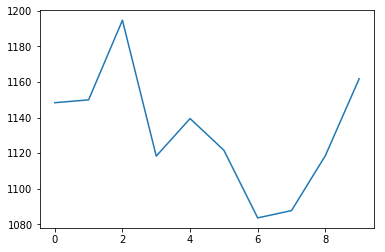

In [13]:
plt.plot(loss_values)
plt.show()

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("---")
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])
    
PATH = '/home/ndg/users/jkurre/mnli/models/bilstm.pt'
torch.save(model, PATH)

In [24]:
for batch_idx, batch in enumerate(test_iterator):
    input_data = batch.text.to(device)
    target_data = batch.target.to(device)
    target_data_one_hot = torch.nn.functional.one_hot(target_data - 1, len(LABEL_TO_INT))

    output = model(input_data)
    max_output = torch.max(output, 1)[1]
    predicted_labels = max_output.view(batch.target.size()).data
    n_correct = (predicted_labels == test_full_batch.label.data).sum()
    print(predicted_labels)
    break

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
